In [ ]:
pip install pybaseball --upgrade pybaseball

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pybaseball as pyb
from itertools import combinations, permutations
import matplotlib.pyplot as plt
from scipy.stats import multinomial
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from concurrent.futures import ThreadPoolExecutor
import warnings
warnings.filterwarnings('ignore')

def figure_outcomes(player_stats):
  return 0
def get_all_players_with_teams(start_season=2024, season=2024):
    """Get all players with their team affiliations."""
    try:
        return pyb.batting_stats(start_season, season, qual=50)
    except Exception as e:
        print(f"Error retrieving batting stats for {season}: {e}")
        return pd.DataFrame()

def filter_by_team(df, team_abbr):
    """Filter DataFrame by team."""
    team_cols = [col for col in df.columns if 'team' in col.lower() or 'tm' in col.lower()]
    if team_cols:
        return df[df[team_cols[0]] == team_abbr]
    print(f"No team column found in DataFrame.")
    return pd.DataFrame()
def filter_by_year(df):
  year_groups = df.groupby(df.year)
  return year_groups

def aggregate_team(df):
    """Aggregate players by team."""
    teams = ['ARI', 'ATL', 'BAL', 'BOS', 'CHC', 'CWS', 'CIN', 'CLE',
             'COL', 'DET', 'HOU', 'KC', 'LAA', 'LAD', 'MIA', 'MIL',
             'MIN', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SD', 'SF',
             'SEA', 'STL', 'TB', 'TEX', 'TOR', 'WSN']
    team_rosters = {}
    for team in teams:
        team_df = filter_by_team(df, team)
        if not team_df.empty:
            team_rosters[team] = team_df
    return team_rosters
test_df = get_all_players_with_teams(start_season=2025, season=2025)
players = aggregate_team(test_df)
NYY_players = filter_by_team(test_df, 'NYY')

In [20]:
#Set seeds cell
np.random.seed(67)
tf.random.set_seed(67)

In [ ]:
# Provided run expectancy matrix
base_matrix = np.array([
    [0.48, 0.25, 0.10],  # Bases empty
    [0.87, 0.48, 0.21],  # Runner on 1st
    [1.12, 0.67, 0.31],  # Runner on 2nd
    [1.38, 0.86, 0.32],  # Runners on 1st & 2nd
    [1.55, 0.96, 0.42],  # Runner on 3rd
    [1.78, 1.31, 0.48],  # Runners on 1st & 3rd
    [2.04, 1.41, 0.67],  # Runners on 2nd & 3rd
    [2.69, 1.61, 0.96]   # Bases loaded
])

base_states = [
    (0, 0, 0), (1, 0, 0), (0, 1, 0), (1, 1, 0),
    (0, 0, 1), (1, 0, 1), (0, 1, 1), (1, 1, 1)
]

def get_run_expectancy(bases_state, outs):
    """Calculates run expectancy for a given base-out state."""
    # Map bases_state tuple to an index for base_matrix
    try:
        state_idx = base_states.index(bases_state)
    except ValueError:
        # Should not happen with valid bases_state, but defensive programming
        return 0.0 # Return 0 if state is somehow invalid

    # Ensure outs is 0, 1, or 2
    if 0 <= outs <= 2:
        return base_matrix[state_idx, outs]
    else:
        return 0.0 # No run expectancy if 3 outs

def get_player_probs(player_row):
    """Enhanced player probability calculation with more baseball outcomes"""
    pa = max(player_row.get('PA', 1), 1)

    # Calculate basic probabilities with defensive programming
    single_prob = player_row.get('1B', 0) / pa
    double_prob = player_row.get('2B', 0) / pa
    triple_prob = player_row.get('3B', 0) / pa
    hr_prob = player_row.get('HR', 0) / pa
    walk_prob = player_row.get('BB', 0) / pa
    hbp_prob = player_row.get('HBP', 0) / pa
    strikeout_prob = player_row.get('SO', 0) / pa

    # Estimate sac fly probability (not directly available in standard stats)
    # Sac flies are roughly 1-2% of PAs, higher for contact hitters
    sac_fly_prob = min(0.02, max(0.005, (1 - strikeout_prob) * 0.02))

    # Estimate other outcomes
    # Groundout probability (part of general outs)
    groundout_prob = (player_row.get('GB', pa * 0.4) / pa) * 0.6  # ~60% of GB become outs
    # Flyout probability
    flyout_prob = (player_row.get('FB', pa * 0.4) / pa) * 0.7  # ~70% of FB become outs

    # Calculate remaining out probability
    total_positive = (single_prob + double_prob + triple_prob + hr_prob +
                     walk_prob + hbp_prob + strikeout_prob + sac_fly_prob +
                     groundout_prob + flyout_prob)
    remaining_out_prob = max(0, 1 - total_positive)

    probs = {
        'single': single_prob,
        'double': double_prob,
        'triple': triple_prob,
        'hr': hr_prob,
        'walk': walk_prob,
        'hbp': hbp_prob,
        'strikeout': strikeout_prob,
        'sac_fly': sac_fly_prob,
        'groundout': groundout_prob,
        'flyout': flyout_prob,
        'out': remaining_out_prob
    }

    # Use expected stats for small sample sizes
    if pa < 50:
        probs['single'] = 0.7 * probs['single'] + 0.3 * player_row.get('xBA', 0.25)
        probs['double'] = 0.7 * probs['double'] + 0.3 * max(0, (player_row.get('xSLG', 0.4) - player_row.get('xBA', 0.25)) / 3)
        probs['hr'] = 0.7 * probs['hr'] + 0.3 * max(0, (player_row.get('xSLG', 0.4) - player_row.get('xBA', 0.25)) / 6)

    # Normalize probabilities
    total = sum(probs.values())
    if total > 0:
        probs = {k: v / total for k, v in probs.items()}
    else:
        # Fallback to league average
        probs = {
            'single': 0.15, 'double': 0.05, 'triple': 0.01, 'hr': 0.03,
            'walk': 0.09, 'hbp': 0.01, 'strikeout': 0.22, 'sac_fly': 0.015,
            'groundout': 0.25, 'flyout': 0.15, 'out': 0.105
        }

    return probs

def simulate_pa(player_probs):
    outcomes = list(player_probs.keys())
    probs = list(player_probs.values())
    return np.random.choice(outcomes, p=probs)

def update_state(bases, outs, outcome, player_row):
    """Enhanced state transition logic with proper handling of all baseball outcomes"""
    runs = 0
    new_bases = bases.copy()
    new_outs = outs

    if outcome == 'hr':
        # Home run - all runners score plus batter
        runs += sum(bases) + 1
        new_bases = [0, 0, 0]

    elif outcome == 'single':
        # Single - runner on 3rd scores, others advance one base
        if bases[2]: runs += 1
        if bases[1]: new_bases[2] = 1
        if bases[0]: new_bases[1] = 1
        new_bases[0] = 1

    elif outcome == 'double':
        # Double - runners on 2nd and 3rd score, runner on 1st goes to 3rd
        if bases[2]: runs += 1
        if bases[1]: runs += 1
        if bases[0]: new_bases[2] = 1
        new_bases[1] = 1
        new_bases[0] = 0

    elif outcome == 'triple':
        # Triple - all runners score, batter to 3rd
        runs += sum(bases)
        new_bases = [0, 0, 1]

    elif outcome == 'walk' or outcome == 'hbp':
        # Walk or HBP - force advancement, run scores if bases loaded
        if all(bases):  # Bases loaded
            runs += 1
        if bases[1]: new_bases[2] = 1
        if bases[0]: new_bases[1] = 1
        new_bases[0] = 1

    elif outcome == 'sac_fly':
        # Sacrifice fly - runner on 3rd scores, batter out, other runners advance if possible
        new_outs += 1
        if bases[2]:  # Runner on 3rd scores
            runs += 1
            new_bases[2] = 0
        # Runners on 1st and 2nd advance if there's space
        if bases[1] and not bases[2]:  # Runner on 2nd advances to 3rd if 3rd is empty
            new_bases[2] = 1
            new_bases[1] = 0
        if bases[0] and not bases[1]:  # Runner on 1st advances to 2nd if 2nd is empty
            new_bases[1] = 1
            new_bases[0] = 0

    elif outcome == 'strikeout':
        new_outs += 1

    elif outcome == 'groundout':
        # Groundout - potential for double play
        new_outs += 1
        gdp_prob = player_row.get('GDP', 0) / max(player_row.get('PA', 1), 1)
        # Double play if runner on 1st and less than 2 outs
        if bases[0] and outs < 2 and gdp_prob > np.random.random():
            new_outs = min(outs + 2, 3)
            new_bases[0] = 0
            # Other runners advance on double play
            if bases[1]:
                new_bases[1] = 0
                new_bases[2] = 1  # Runner on 2nd advances to 3rd
            if bases[2]:
                runs += 1  # Runner on 3rd scores
                new_bases[2] = 0

    elif outcome == 'flyout':
        # Flyout - runner on 3rd can tag up and score
        new_outs += 1
        if bases[2] and outs < 2:  # Runner on 3rd can tag up with less than 2 outs
            # 70% chance runner on 3rd scores on flyout
            if np.random.random() < 0.7:
                runs += 1
                new_bases[2] = 0

    elif outcome == 'out':
        # Generic out - potential for double play
        new_outs += 1
        gdp_prob = player_row.get('GDP', 0) / max(player_row.get('PA', 1), 1)
        if bases[0] and outs < 2 and gdp_prob > np.random.random():
            new_outs = min(outs + 2, 3)
            new_bases[0] = 0
            if bases[1]: new_bases[1] = 0
            if bases[2]: new_bases[2] = 0

    return new_bases, new_outs, runs

def simulate_inning(lineup, player_probs, batter_idx, game_id, inning_num):
    outs = 0
    bases = [0, 0, 0]
    runs_in_inning = 0 # Track runs scored only within this inning
    inning_pbp_events = [] # Initialize PBP log for the inning

    while outs < 3:
        # Record pre-AB state
        pre_ab_bases_tuple = tuple(bases)
        pre_ab_outs = outs

        # Calculate RE_start
        RE_start = get_run_expectancy(pre_ab_bases_tuple, pre_ab_outs)

        batter = lineup[batter_idx % len(lineup)]
        current_batter_position = (batter_idx % len(lineup)) + 1 # 1-indexed position
        batter_stats = player_probs['rows'][batter] # Get full stats for the current batter

        outcome = simulate_pa(player_probs[batter]) # player_probs[batter] contains player-specific outcome probabilities

        # Simulate the play and get runs scored this AB
        new_bases, new_outs, runs_scored_this_ab = update_state(bases, outs, outcome, player_probs['rows'][batter])

        # Update cumulative runs and state for the inning
        runs_in_inning += runs_scored_this_ab
        bases = new_bases
        outs = new_outs

        # Calculate RE_end (if 3 outs, RE_end is 0)
        if new_outs == 3: # Inning ends, RE_end is 0
            RE_end = 0.0
        else:
            RE_end = get_run_expectancy(tuple(new_bases), new_outs)

        # Calculate Run_Value_RE24
        run_value_re24 = runs_scored_this_ab + RE_end - RE_start

        # Log the play-by-play event
        inning_pbp_events.append({
            'Game ID': game_id,
            'Inning': inning_num,
            'Batter': batter,
            'Lineup Position': current_batter_position,
            'Pre-AB Bases': pre_ab_bases_tuple,
            'Pre-AB Outs': pre_ab_outs,
            'RE_start': RE_start,
            'Post-AB Bases': tuple(new_bases),
            'Post-AB Outs': new_outs,
            'RE_end': RE_end,
            'Event Outcome': outcome,
            'Run_Value_RE24': run_value_re24,
            # Batter's full statistics
            'batter_wOBA': batter_stats.get('wOBA', 0),
            'batter_OBP': batter_stats.get('OBP', 0),
            'batter_SLG': batter_stats.get('SLG', 0),
            'batter_xwOBA': batter_stats.get('xwOBA', 0),
            'batter_xBA': batter_stats.get('xBA', 0),
            'batter_xSLG': batter_stats.get('xSLG', 0),
            'batter_ISO': batter_stats.get('ISO', 0),
            'batter_BB_rate': batter_stats.get('BB', 0) / max(batter_stats.get('PA', 1), 1),
            'batter_K_rate': batter_stats.get('SO', 0) / max(batter_stats.get('PA', 1), 1),
            'batter_HR_rate': batter_stats.get('HR', 0) / max(batter_stats.get('PA', 1), 1),
            'batter_contact_rate': 1 - (batter_stats.get('SO', 0) / max(batter_stats.get('PA', 1), 1))
        })

        batter_idx += 1

    return runs_in_inning, batter_idx, inning_pbp_events

def simulate_game(lineup, player_probs, game_id, innings=9):
    total_runs = 0
    batter_idx = 0
    pbp_log = [] # Initialize PBP log for the entire game

    for inning in range(1, innings + 1):
        runs_this_inning, batter_idx, inning_pbp_events = simulate_inning(lineup, player_probs, batter_idx, game_id, inning)
        total_runs += runs_this_inning
        pbp_log.extend(inning_pbp_events) # Append inning events to game log

    return total_runs, pbp_log

def remove_duplicates_preserve_order(lineup):
    """Remove duplicate names while preserving order."""
    seen = set()
    result = []
    for player in lineup:
        if player not in seen:
            seen.add(player)
            result.append(player)
    return result

def generate_pbp_dataset(df, n_games=1000, innings_per_game=9, n_players_in_lineup=9):
    """
    Simulates a large number of games using randomly chosen lineups and collects
    all Play-by-Play (PBP) events into a single DataFrame.

    Each event includes the batter's full statistics and their explicit lineup position.

    Args:
        df (pd.DataFrame): DataFrame of all available players with their statistics.
        n_games (int): Number of games to simulate.
        innings_per_game (int): Number of innings per game.
        n_players_in_lineup (int): Number of players in a lineup (typically 9).

    Returns:
        pd.DataFrame: A DataFrame containing the comprehensive PBP dataset.
    """
    print(f"Generating {n_games} games for PBP dataset...")

    all_pbp_events = []
    available_players_names = df['Name'].unique().tolist()

    if len(available_players_names) < n_players_in_lineup:
        raise ValueError(f"Not enough unique players in DataFrame (found {len(available_players_names)}) to form a {n_players_in_lineup}-player lineup.")

    for game_idx in range(n_games):
        if game_idx % (n_games // 10) == 0:
            print(f"  Simulating game {game_idx}/{n_games}")

        game_id = f"Game_{game_idx+1:04d}"

        # b. Randomly select n_players_in_lineup unique players
        current_lineup = np.random.choice(available_players_names, size=n_players_in_lineup, replace=False).tolist()

        # c. Create player_probs and player_rows dictionaries
        player_probs = {}
        player_probs['rows'] = {name: df[df['Name'] == name].iloc[0] for name in current_lineup}
        for name in current_lineup:
            player_probs[name] = get_player_probs(player_probs['rows'][name])

        # d. Call the simulate_game function
        _, game_pbp_events = simulate_game(current_lineup, player_probs, game_id, innings=innings_per_game)

        # e. Accumulate all PBP events
        all_pbp_events.extend(game_pbp_events)

    # 3. Convert the master list of PBP events into a single pandas DataFrame
    pbp_df = pd.DataFrame(all_pbp_events)
    print(f"Generated PBP dataset with {len(pbp_df)} events.")

    return pbp_df


# 5. Call generate_pbp_dataset using the comprehensive_players DataFrame
# Ensure 'comprehensive_players' is defined from previous cells.
# Fallback if comprehensive_players is not available (though it should be).
if 'comprehensive_players' not in locals() or comprehensive_players.empty:
    print("Loading players for PBP dataset generation...")
    # Assuming get_all_players_with_teams and filter_by_team are available
    all_players_df = get_all_players_with_teams(2025, 2025)
    team_rosters = aggregate_team(all_players_df)
    all_teams_players_list = []
    for team, team_df in team_rosters.items():
        if len(team_df) >= 9:
            all_teams_players_list.append(team_df.nlargest(12, 'wOBA'))
    if all_teams_players_list:
        comprehensive_players = pd.concat(all_teams_players_list, ignore_index=True)
    else:
        # As a last resort, use NYY_players if comprehensive cannot be formed
        comprehensive_players = NYY_players


if not comprehensive_players.empty and len(comprehensive_players['Name'].unique()) >= 9:
    pbp_full_dataset = generate_pbp_dataset(
        df=comprehensive_players,
        n_games=1000,
        innings_per_game=9,
        n_players_in_lineup=9
    )

    # 6. Display the head and general information
    print("\n--- Head of the PBP Full Dataset ---")
    print(pbp_full_dataset.head())
    print("\n--- Info of the PBP Full Dataset ---")
    pbp_full_dataset.info()
else:
    print("Cannot generate PBP dataset: 'comprehensive_players' is empty or has fewer than 9 unique players.")


Generating 1000 games for PBP dataset...
  Simulating game 0/1000
  Simulating game 100/1000
  Simulating game 200/1000
  Simulating game 300/1000
  Simulating game 400/1000
  Simulating game 500/1000
  Simulating game 600/1000
  Simulating game 700/1000
  Simulating game 800/1000
  Simulating game 900/1000
Generated PBP dataset with 39568 events.

--- Head of the PBP Full Dataset ---
     Game ID  Inning              Batter  Lineup Position Pre-AB Bases  \
0  Game_0001       1   Daniel Schneemann                1    (0, 0, 0)   
1  Game_0001       1           Alec Bohm                2    (0, 0, 0)   
2  Game_0001       1     Blaze Alexander                3    (0, 0, 0)   
3  Game_0001       1           Joey Bart                4    (0, 0, 0)   
4  Game_0001       1  Moises Ballesteros                5    (1, 0, 0)   

   Pre-AB Outs  RE_start Post-AB Bases  Post-AB Outs  RE_end  ... batter_OBP  \
0            0      0.48     (0, 0, 0)             1    0.25  ...      0.283   
1      

Training Front Office Lineup Model...
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2584 - mae: 69.6874 - val_loss: 0.1472 - val_mae: 70.1149
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1173 - mae: 69.6796 - val_loss: 0.0369 - val_mae: 69.9671
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0298 - mae: 69.7425 - val_loss: 0.0194 - val_mae: 69.9269
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0178 - mae: 69.5756 - val_loss: 0.0129 - val_mae: 69.9111
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0130 - mae: 69.4080 - val_loss: 0.0106 - val_mae: 69.9048
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0096 - mae: 69.7176 - val_loss: 0.0096 - val_mae: 69.9035
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0094 - mae: 69.5412 - val_loss: 0.0094 - val_mae: 69.9038
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0081 - mae: 69.4160 - val_loss: 0.0084 - val_mae: 69

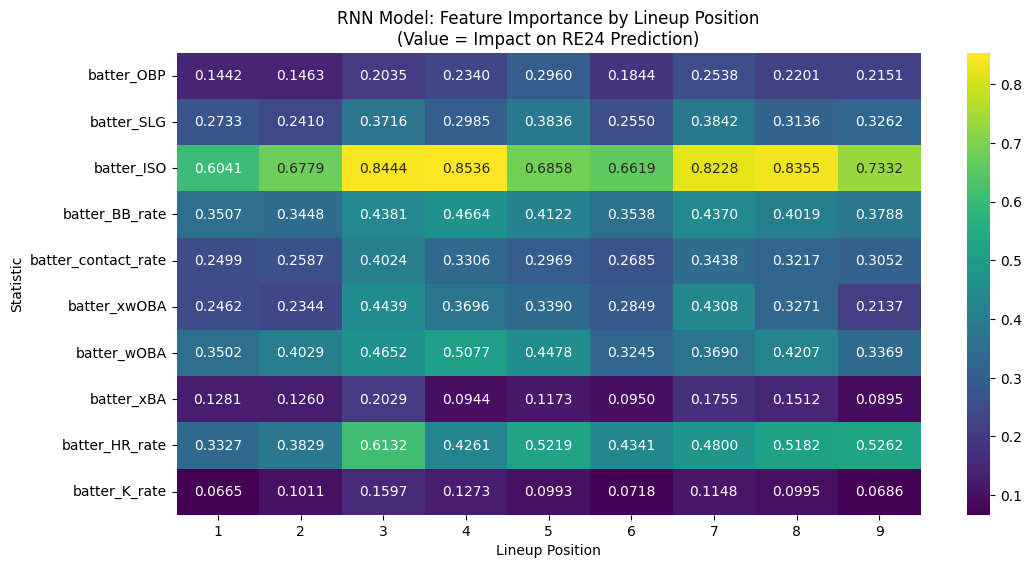


--- FRONT OFFICE ANALYSIS ---
Top Feature for Leadoff (1): batter_ISO
Top Feature for Cleanup (4): batter_ISO
Top Feature for #9 Hitter: batter_ISO


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, TimeDistributed, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. FRONT OFFICE DATA PREP ---

# Key Batter Stats we want to analyze (The "Inputs")
feature_cols = [
    'batter_OBP', 'batter_SLG', 'batter_ISO',
    'batter_BB_rate', 'batter_contact_rate',
    'batter_xwOBA', 'batter_wOBA', 'batter_xBA', 'batter_HR_rate',
    'batter_K_rate'
]

# Context features (The model needs these to understand the "situation")
context_cols = ['Pre-AB Outs']

# Target
target_col = 'Run_Value_RE24'

# Filter dataset (assuming pbp_full_dataset is loaded from your previous code)
df_clean = pbp_full_dataset.copy()

# One-Hot Encode Bases for the Model (Crucial for context)
# Convert (0,0,0) tuples to string or integer logic for encoding, or just simple flags
df_clean['on_1b'] = df_clean['Pre-AB Bases'].apply(lambda x: x[0])
df_clean['on_2b'] = df_clean['Pre-AB Bases'].apply(lambda x: x[1])
df_clean['on_3b'] = df_clean['Pre-AB Bases'].apply(lambda x: x[2])
base_cols = ['on_1b', 'on_2b', 'on_3b']

final_features = feature_cols + context_cols + base_cols

# Scale the data (Neural Networks require normalized data)
scaler = StandardScaler()
df_clean[feature_cols] = scaler.fit_transform(df_clean[feature_cols])

# --- 2. SEQUENCE GENERATION (RNN FORMAT) ---
# We group by Game and Inning to create "sequences" of at-bats.
# The RNN learns that "Outcome A -> Outcome B" leads to high Run Value.

sequences = []
targets = []
lineup_positions = [] # Track positions to map back later

# Group by Game and Inning
grouped = df_clean.groupby(['Game ID', 'Inning'])

for name, group in grouped:
    # Sort by how they appeared in the inning (index preservation)
    seq = group[final_features].values
    target = group[target_col].values
    pos = group['Lineup Position'].values

    sequences.append(seq)
    targets.append(target)
    lineup_positions.append(pos)

# Pad sequences so they are all the same length (max bats in an inning)
# We use a masking value of -99 that the model will ignore
MAX_SEQ_LEN = 15
X_padded = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post', dtype='float32', value=-99)
y_padded = pad_sequences(targets, maxlen=MAX_SEQ_LEN, padding='post', dtype='float32', value=-99)
pos_padded = pad_sequences(lineup_positions, maxlen=MAX_SEQ_LEN, padding='post', dtype='int32', value=0)

# Split Training/Testing
X_train, X_test, y_train, y_test, pos_train, pos_test = train_test_split(
    X_padded, y_padded, pos_padded, test_size=0.2, random_state=42
)

# Reshape y_train and y_test to match the model's output shape
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

# --- 3. THE RNN MODEL ARCHITECTURE ---

model = Sequential([
    # Masking layer tells LSTM to ignore the padded -99 values
    Masking(mask_value=-99, input_shape=(MAX_SEQ_LEN, len(final_features))),

    # LSTM Layer: Captures the "flow" of the inning
    # Bidirectional allows it to see the context of the whole inning context
    Bidirectional(LSTM(64, return_sequences=True)),

    # TimeDistributed Dense: Outputs a prediction for *every* step in the sequence
    TimeDistributed(Dense(32, activation='relu')),
    TimeDistributed(Dense(1, activation='linear')) # Predicting RE24 (Continuous)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Training Front Office Lineup Model...")
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# --- 4. FEATURE IMPORTANCE BY POSITION (The "Moneyball" Insight) ---

def calculate_permutation_importance_by_position(model, X_data, y_data, pos_data, feature_names):
    """
    Determines which stats are most important for EACH lineup position
    by shuffling one feature at a time and measuring error increase.
    """
    importances = {pos: {} for pos in range(1, 10)}

    # Get baseline predictions and error
    y_pred_base = model.predict(X_data, verbose=0)

    # Flatten arrays for easy filtering by position
    # We only care about the actual events, not the padding
    mask = y_data != -99

    # Calculate baseline MSE per position
    baseline_mse = {}
    for pos in range(1, 10):
        pos_mask = (pos_data == pos) & mask.squeeze()
        if np.sum(pos_mask) > 0:
            err = (y_data[pos_mask] - y_pred_base.squeeze()[pos_mask])**2
            baseline_mse[pos] = np.mean(err)

    print("\nCalculating Feature Importance (this may take a moment)...")

    # Loop through every feature (OBP, SLG, ISO, etc.)
    for i, feature in enumerate(feature_names):
        # We only shuffle the specific feature column
        X_shuffled = X_data.copy()

        # Shuffle logic: Shuffle the feature across the whole batch
        # (This breaks the relationship between that stat and the result)
        X_shuffled[:, :, i] = np.random.permutation(X_shuffled[:, :, i])

        # Predict with broken feature
        y_pred_shuffled = model.predict(X_shuffled, verbose=0)

        # Calculate new MSE per position
        for pos in range(1, 10):
            pos_mask = (pos_data == pos) & mask.squeeze()
            if np.sum(pos_mask) > 0:
                err = (y_data[pos_mask] - y_pred_shuffled.squeeze()[pos_mask])**2
                new_mse = np.mean(err)

                # Importance = How much worse did the model get?
                # Higher number = Stat is MORE important
                importances[pos][feature] = new_mse - baseline_mse[pos]

    return pd.DataFrame(importances)

# Run the analysis only on batter stats (indices 0 to 6 in our feature list)
batter_stat_names = feature_cols
batter_stat_indices = [final_features.index(f) for f in feature_cols]

# We pass the full data, but logic inside handles the specific column shuffling
importance_df = calculate_permutation_importance_by_position(
    model, X_test, y_test, pos_test, final_features
)

# Filter to just show Batter Stats (exclude context like "Outs" which are obviously important)
importance_df = importance_df.loc[batter_stat_names]

# --- 5. VISUALIZATION ---

plt.figure(figsize=(12, 6))
sns.heatmap(importance_df, annot=True, cmap='viridis', fmt='.4f')
plt.title('RNN Model: Feature Importance by Lineup Position\n(Value = Impact on RE24 Prediction)')
plt.xlabel('Lineup Position')
plt.ylabel('Statistic')
plt.show()

print("\n--- FRONT OFFICE ANALYSIS ---")
print("Top Feature for Leadoff (1):", importance_df[1].idxmax())
print("Top Feature for Cleanup (4):", importance_df[4].idxmax())
print("Top Feature for #9 Hitter:", importance_df[9].idxmax())

In [ ]:
importance_df

,1,2,3,4,5,6,7,8,9
batter_OBP,0.119942,0.145885,0.197080,0.136180,0.101073,0.103333,0.126499,0.120804,0.122634
batter_SLG,0.285338,0.323039,0.407575,0.374981,0.286616,0.290737,0.318263,0.303714,0.310584
batter_ISO,0.275901,0.319148,0.420639,0.343283,0.272614,0.294088,0.323404,0.289436,0.298943
batter_BB_rate,0.296808,0.308427,0.377883,0.365879,0.287433,0.293735,0.320678,0.327461,0.346453
batter_contact_rate,0.428814,0.485861,0.583285,0.535829,0.449588,0.455868,0.493243,0.469758,0.472654
batter_xwOBA,0.318683,0.305977,0.333187,0.403701,0.374930,0.348365,0.355065,0.379153,0.393686
batter_wOBA,0.567855,0.623617,0.684312,0.634009,0.571868,0.563539,0.578791,0.552494,0.595357
batter_xBA,0.129523,0.125677,0.204619,0.175312,0.122253,0.111862,0.146215,0.149769,0.141629
batter_HR_rate,0.386100,0.422515,0.473789,0.420195,0.371787,0.396230,0.400000,0.408888,0.424060
batter_K_rate,0.377482,0.376872,0.489088,0.504004,0.397435,0.404985,0.458346,0.437708,0.434232


In [ ]:
nyy_players_sorted_woba = NYY_players.sort_values(by='wOBA', ascending=False)
woba_importance = {
    1: 0.567855,
    2: 0.623617,
    3: 0.684312,
    4: 0.634009,
    5: 0.571868,
    6: 0.563539,
    7: 0.578791,
    8: 0.552494,
    9: 0.595357
}

optimal_order_indices = sorted(woba_importance, key=woba_importance.get, reverse=True)
players = nyy_players_sorted_woba.head(9).copy().reset_index(drop=True)
fin = [None] * 9

for rank, player in zip(optimal_order_indices, players.index):
  fin[rank-1] = players.loc[player]['Name']

3. Aaron Judge
4. Giancarlo Stanton
2. Ben Rice
9. Trent Grisham
7. Jazz Chisholm Jr.
5. Cody Bellinger
1. Jasson Dominguez
6. Paul Goldschmidt
8. DJ LeMahieu


In [21]:
#Run the simulation to see if this lineup has any statistical difference with this same lineup generator:
from scipy import stats
#have fin setup
control = [
    "Trent Grisham", "Cody Bellinger", "Aaron Judge", "Ben Rice", "Giancarlo Stanton",
    "Jazz Chisholm Jr.", "Anthony Volpe", "Austin Wells", "DJ LeMahieu"
]

def setup_player_probs(names, df):
  probs_dict = {'rows': {}}
  for name in names:
      row = df[df['Name'] == name].iloc[0]
      probs_dict['rows'][name] = row
      probs_dict[name] = get_player_probs(row)
  return probs_dict

opt_lin = setup_player_probs(fin, comprehensive_players)
control_lin = setup_player_probs(control, comprehensive_players)

N_GAMES = 10000
print(f"Simulating {N_GAMES} games per lineup...")

def run_batch_simulation(lineup, probs, n):
    results = []
    for i in range(n):
        # We only care about total runs for the t-test
        score, _ = simulate_game(lineup, probs, game_id=f"Sim_{i}", innings=9)
        results.append(score)
    return results


opt_res = run_batch_simulation(fin, opt_lin, N_GAMES)
control_res = run_batch_simulation(control, control_lin, N_GAMES)


mean_opt = np.mean(opt_res)
std_opt = np.std(opt_res)
mean_control = np.mean(control_res)
std_control = np.std(control_res)

t_stat, p_val = stats.ttest_ind(opt_res, control_res, alternative='greater', equal_var=False)


#Run the t-test

print(f"Optimal Lineup Mean: {mean_opt}")
print(f"Control Lineup Mean: {mean_control}")
print(f"Optimal Lineup STD: {std_opt}")
print(f"Control Lineup STD: {std_control}")

print(f"The p value of the t-test is {p_val}")

#Range of runs and wins added per year
wins_added_tuple = ((mean_opt - mean_control) * 162 / 9, (mean_opt - mean_control) * 162 / 10)
print(f"This lineup has added anywhere between {wins_added_tuple[1]} and {wins_added_tuple[0]} wins")

Simulating 10000 games per lineup...
Optimal Lineup Mean: 5.496
Control Lineup Mean: 5.4572
Optimal Lineup STD: 3.693586874570571
Control Lineup STD: 3.5842388536480096
The p value of the t-test is 0.22547961369493524
This lineup has added anywhere between 0.6285600000000027 and 0.698400000000003 wins
